In [1]:
import pandas as pd
from numpy import *
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 1.1 回归树的构建
- 叶节点是一个值：当前叶子所有样本标签均值
- 误差衡量：总方差，表示一组数据的混乱度，是本组所有数据与这组数据均值之差的平方和

**基础函数**

In [2]:
#数据读取
def loadDataSet(filename):
    dataMat=[]
    fr=open(filename,'r')
    for line in fr.readlines():
        curLine=line.strip().split('\t')
        fltLine=list(map(float,curLine)) #将curLine各元素转换为float类型
        dataMat.append(fltLine)
    return mat(dataMat)

#二分数据
def binSplitDataSet(dataset,feat,val):
    mat0=dataset[nonzero(dataset[:,feat]>val)[0],:] #数组过滤选择特征大于指定值的数据
    mat1=dataset[nonzero(dataset[:,feat]<=val)[0],:] #数组过滤选择特征小于指定值的数据
    return mat0,mat1

In [3]:
#定义回归树的叶子(该叶子上各样本标签的均值)
def regLeaf(dataset):
    return mean(dataset[:,-1])

#定义连续数据的混乱度(总方差，即连续数据的混乱度=(该组各数据-该组数据均值)**2，即方差*样本数)）
def regErr(dataset):
    return var(dataset[:-1])*shape(dataset)[0]

**最佳特征/特征值选择函数**
- 逻辑
    - 对每个特征
        - 对每个特征值
            - 将数据切成两份
            - 计算切分后数据的误差(数据的混乱度)
            - 如果当前误差(混乱度)小于当前最小误差(混乱度)，那么将当前切分点设定为最佳切分点，并更新最小误差
    - 返回最佳切分特征和阈值(最佳切分特征值)

In [4]:
#最佳特征以及最佳特征值选择函数
#leafType为叶节点取值，默认为regleaf，即取样本标签均值，对于模型树，叶节点是一个线性模型
#errType为数据误差(混乱度)计算方式，默认为regErr，总方差
#ops[0]为以最佳特征及特征值切分数据前后，数据混乱度的变化阈值，若小于该阈值，不切分
#ops[1]为切分后两块数据的最少样本数，若少于该值，不切分
#可以预想，回归树形状对ops[0],ops[1]很敏感，若这两个值过小，回归树会很臃肿，过拟合
def chooseBestSplit(dataset,leafType=regLeaf,errType=regErr,ops=(1,4)):
    tolS=ops[0];tolN=ops[1];m,n=shape(dataset)
    S=errType(dataset);bestS=inf;beatIndex=0;bestVal=0
    if len(set(dataset[:,-1].T.tolist()[0]))==1: #若只有一个类别
        return None,leafType(dataset)
    for featIndex in range(n-1):
        for splitVal in set(dataset[:,featIndex].T.tolist()[0]):
            mat0,mat1=binSplitDataSet(dataset,featIndex,splitVal)
            #若切分后两块数据的最少样本数少于设定值，不切分
            if (shape(mat0)[0]<tolN) or (shape(mat1)[0]<tolN): 
                continue
            newS=errType(mat0)+errType(mat1)
            if newS<bestS:
                bestIndex=featIndex;bestVal=splitVal;bestS=newS
    #若以最佳特征及特征值切分后的数据混乱度与原数据混乱度差值小于阈值，不切分
    if (S-bestS)<tolS:
        return None,leafType(dataset)
    mat0,mat1=binSplitDataSet(dataset,bestIndex,bestVal)
    #若以最佳特征及特征值切分后两块数据的最少样本数少于设定值，不切分
    if (shape(mat0)[0]<tolN) or (shape(mat1)[0]<tolN):
        return None,leafType(dataset)
    return bestIndex,bestVal

**回归树构建函数**
- 逻辑
    - 找到最佳切分特征和最佳切分值
    - 若特征不能再切分，则返回该结点值作为叶节点
    - 以最佳切分值为界，执行二元切分，得到左右子树
    - 对左子树调用自身(createTree)
    - 对右子树调用自身(createTree)

In [5]:
#构建回归树
def createTree(dataset,leafType=regLeaf,errType=regErr,ops=(1,4)):
    feat,val=chooseBestSplit(dataset,leafType,errType,ops)
    if feat==None:
        return val
    regTree={}
    regTree['spFeat']=feat
    regTree['spVal']=val
    lSet,rSet=binSplitDataSet(dataset,feat,val)
    regTree['left']=createTree(lSet,leafType,errType,ops)
    regTree['right']=createTree(rSet,leafType,errType,ops)
    return regTree

**测试**

In [6]:
dataMat1=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\ex00.txt')
regTree1=createTree(dataMat1)
regTree1

{'left': 1.0180967672413792,
 'right': -0.04465028571428572,
 'spFeat': 0,
 'spVal': 0.48813}

In [7]:
dataMat2=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\ex0.txt')
regTree2=createTree(dataMat2,ops=(1,4))
regTree2

{'left': {'left': {'left': 3.9787303333333335,
   'right': 3.12968256,
   'spFeat': 1,
   'spVal': 0.845148},
  'right': 1.980035071428571,
  'spFeat': 1,
  'spVal': 0.582002},
 'right': {'left': 1.0289583666666666,
  'right': -0.023838155555555553,
  'spFeat': 1,
  'spVal': 0.197834},
 'spFeat': 1,
 'spVal': 0.39435}

Text(0.5,1,'regTree2原始数据分布')

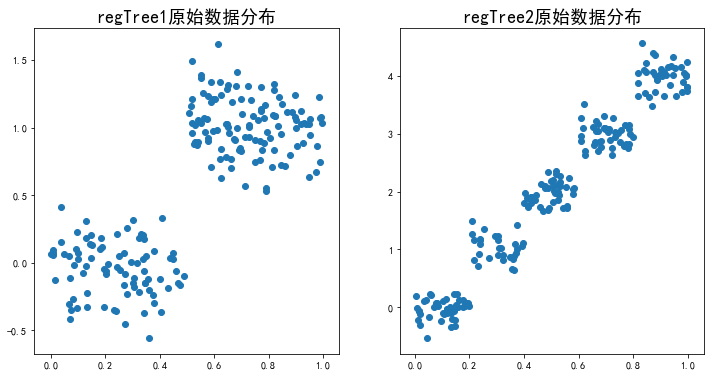

In [8]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot(121)
ax1.scatter(dataMat1[:,0].flatten().A[0],dataMat1[:,1].flatten().A[0])
plt.title('regTree1原始数据分布',fontsize=18)
ax2=fig.add_subplot(122)
ax2.scatter(dataMat2[:,1].flatten().A[0],dataMat2[:,2].flatten().A[0])
plt.title('regTree2原始数据分布',fontsize=18)

- 可以看到，ex00原始数据分布为两类，regTree1回归树也有两个叶节点
- 可以看到，ex0原始数据分布为五类，regTree2回归树也有五个叶节点

### 1.2 回归树的剪枝
**过拟合->剪枝**
- 剪枝：通过降低决策树复杂度避免过拟合
    - 预剪枝：在chooseBestSplit函数中的几个提前终止条件(切分样本小于阈值、混乱度减弱小于阈值)，都是预剪枝（参数敏感）
    - 后剪枝：使用测试集对训练出的回归树进行剪枝（由于不需要用户指定，后剪枝是一种更为理想化的剪枝方法）
- 后剪枝过程：对训练好的回归树，自上而下找到叶节点，用测试集来判断将这些叶节点合并是否能降低测试误差，若能，则合并
- 逻辑
    - 若存在任意子集是树，则该子集递归调用剪枝过程(直到所有子集都为叶节点)
    - 计算当前两个叶节点合并后的误差(混乱度)
    - 计算不合并的误差(混乱度)
    - 若合并能降低误差，则将当前两个叶节点合并

In [9]:
#判断是否是一棵树(字典)
def isTree(obj):
    return (type(obj).__name__=='dict')

#得到树所有叶节点的均值
def getMean(tree):
    #若子树仍然是树，则递归调用getMeant直到叶节点
    if isTree(tree['left']):
        tree['left']=getMean(tree['left'])
    if isTree(tree['right']):
        tree['right']=getMean(tree['right'])
    return (tree['left']+tree['right'])/2.0

#剪枝函数：对训练好的回归树，自上而下找到叶节点，用测试集来判断将这些叶节点合并是否能降低测试误差，若能则合并
def prune(tree,testData):
    #若无测试数据，则直接返回树所有叶节点的均值(塌陷处理)
    if shape(testData)[0]==0:
        return getMean(tree)
    #若存在任意子集是树，则将测试集按当前树的最佳切分特征和特征值切分(子集剪枝用)
    if isTree(tree['left']) or isTree(tree['right']):
        lSet,rSet=binSplitDataSet(testData,tree['spFeat'],tree['spVal'])
    #若存在任意子集是树，则该子集递归调用剪枝过程(利用刚才切分好的训练集)
    if isTree(tree['left']):
        tree['left']=prune(tree['left'],lSet)
    if isTree(tree['right']):
        tree['right']=prune(tree['right'],rSet)
    #若当前子集都是叶节点，则计算该二叶节点合并前后的误差，决定是否合并
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet,rSet=binSplitDataSet(testData,tree['spFeat'],tree['spVal'])
        errNotMerge=sum(power(lSet[:,-1].T.tolist()[0]-tree['left'],2))+sum(power(rSet[:,-1].T.tolist()[0]-tree['right'],2))
        treeMean=(tree['left']+tree['right'])/2.0
        errMerge=sum(power(testData[:,-1].T.tolist()[0]-treeMean,2))
        if errMerge<errNotMerge:
            print("merging")
            return treeMean
        else:
            return tree
    else:
        return tree

**测试**

In [10]:
#构建回归树，可以看到，该回归树非常臃肿，过拟合
dataMat3=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\ex2.txt')
regTree3=createTree(dataMat3,ops=(1,2))
regTree3

{'left': {'left': {'left': 92.5239915,
   'right': 117.9732555,
   'spFeat': 0,
   'spVal': 0.965969},
  'right': {'left': {'left': {'left': {'left': 96.11312898113208,
      'right': 83.8429785,
      'spFeat': 0,
      'spVal': 0.740859},
     'right': {'left': {'left': 107.12406899999999,
       'right': {'left': 121.985343,
        'right': {'left': {'left': 108.36455048148147,
          'right': 101.965592,
          'spFeat': 0,
          'spVal': 0.582311},
         'right': 113.67628066666667,
         'spFeat': 0,
         'spVal': 0.560301},
        'spFeat': 0,
        'spVal': 0.706961},
       'spFeat': 0,
       'spVal': 0.710234},
      'right': 92.59851833333333,
      'spFeat': 0,
      'spVal': 0.548539},
     'spFeat': 0,
     'spVal': 0.729397},
    'right': 110.38113949999999,
    'spFeat': 0,
    'spVal': 0.537834},
   'right': 106.3486936,
   'spFeat': 0,
   'spVal': 0.531944},
  'spFeat': 0,
  'spVal': 0.958512},
 'right': {'left': 12.50675925,
  'right': {'left

In [11]:
testData=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\ex2test.txt')
prune(regTree3,testData)

merging
merging
merging
merging
merging
merging
merging
merging


{'left': {'left': 105.2486235,
  'right': {'left': {'left': {'left': {'left': 96.11312898113208,
      'right': 83.8429785,
      'spFeat': 0,
      'spVal': 0.740859},
     'right': {'left': {'left': 107.12406899999999,
       'right': {'left': 121.985343,
        'right': {'left': 105.16507124074073,
         'right': 113.67628066666667,
         'spFeat': 0,
         'spVal': 0.560301},
        'spFeat': 0,
        'spVal': 0.706961},
       'spFeat': 0,
       'spVal': 0.710234},
      'right': 92.59851833333333,
      'spFeat': 0,
      'spVal': 0.548539},
     'spFeat': 0,
     'spVal': 0.729397},
    'right': 110.38113949999999,
    'spFeat': 0,
    'spVal': 0.537834},
   'right': 106.3486936,
   'spFeat': 0,
   'spVal': 0.531944},
  'spFeat': 0,
  'spVal': 0.958512},
 'right': {'left': 12.50675925,
  'right': {'left': -1.1461750000000006,
   'right': {'left': -8.436749,
    'right': {'left': {'left': -5.8106915,
      'right': {'left': 14.38417875,
       'right': -3.7693815833

- **可以看到，虽然有6个叶节点被剪掉了，但仍然有很多叶节点保留->后剪枝可能不如预剪枝有效，因此一般为了寻求最佳模型，会同时使用两种剪枝技术**

### 2.1 模型树的构建
- 模型树的叶节点是一个线性回归模型：当前叶子所有样本的线性回归模型
- 比回归树有更好的可解释性、更高的预测准确度
- 误差衡量：类比线性回归误差，用线性模型对数据拟合，计算真实值与拟合值之差，求差值的平方和
- 实现：通用函数，算法逻辑与createTree()一致，只需改变其中的叶节点计算方法leafType()和误差计算方法errType()

In [12]:
#叶节点计算方法：该叶节点所有样本的标准线性回归模型，算法与linearRegression()一致
def linearSolve(dataset):
    m,n=shape(dataset)
    X=mat(ones((m,n)));Y=mat(ones((m,1)))
    X[:,1:n]=dataset[:,0:n-1] #X第一列为常数项1
    Y=dataset[:,-1]
    xTx=X.T*X
    if linalg.det(xTx)==0.0:
        raise NameError("矩阵为奇异矩阵，不可逆，尝试增大ops的第二个参数")
    ws=xTx.I*(X.T*Y)
    return ws,X,Y

def modelLeaf(dataset):
    ws,X,Y=linearSolve(dataset)
    return ws

#误差计算方法：用线性模型对数据拟合，计算真实值与拟合值之差，求差值的平方和
def modelErr(dataset):
    ws,X,Y=linearSolve(dataset)
    yPred=X*ws
    return sum(power(Y-yPred,2))

In [13]:
dataMat4=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\exp2.txt')
modelTree1=createTree(dataMat4,leafType=modelLeaf,errType=modelErr,ops=(1,10))
modelTree1

{'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]), 'right': matrix([[3.46877936],
         [1.18521743]]), 'spFeat': 0, 'spVal': 0.285477}

In [14]:
float(modelTree1['left'][0])
float(modelTree1['spVal'])

0.285477

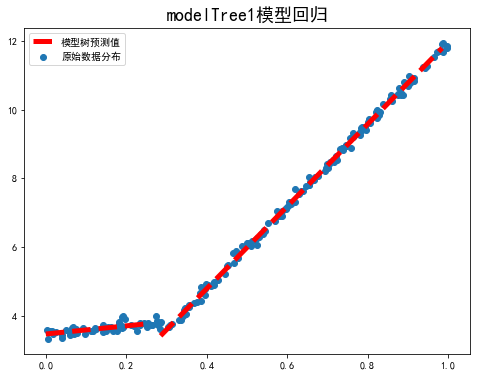

In [15]:
fig=plt.figure(figsize=(8,6))
x1=arange(0.0,float(modelTree1['spVal']),0.05)
x2=arange(float(modelTree1['spVal']),1.0,0.05)
ax1=fig.add_subplot(111)
ax1.scatter(dataMat4[:,0].flatten().A[0],dataMat4[:,1].flatten().A[0],label='原始数据分布')
ax1.plot(x2,float(modelTree1['left'][0])+float(modelTree1['left'][1])*x2,'r--',linewidth=5,label='模型树预测值')
ax1.plot(x1,float(modelTree1['right'][0])+float(modelTree1['right'][1])*x1,'r--',linewidth=5)
plt.title('modelTree1模型回归',fontsize=18)
plt.legend()

- 可以看到，模型树对数据的预测更准确合理

### 2.2 模型树的剪枝
- 预剪枝：增大tolN，切分的最少样本数，从而更客观地建模
- 后剪枝：逻辑与回归树剪枝一致，只需更换其中的误差计算方式
- **关键点：计算叶节点合并前后的误差，决定是否合并**
    - 模型树，两个叶节点合并前的误差=((左叶子真实值-拟合值)的平方和+(右叶子真实值-拟合值)的平方和)
    - 模型树，两个叶节点合并后的误差=(左右真实值-左右拟合值)的平方和
    - 难点在于如何求左右拟合值，即求上层节点的回归系数wsMerge：用上层节点的traindata,通过linearSolve(traindata)求得，上层节点的traindata在lTrain,rTrain的递归中已经求好了

In [16]:
#判断是否是一棵树(字典)
def isTree(obj):
    return (type(obj).__name__=='dict')

#剪枝函数：对训练好的模型树，自上而下找到叶节点，用测试集来判断将这些叶节点合并是否能降低测试误差，若能则合并
def modelPrune(tree,trainData,testData):
    m,n=shape(testData)
    #若无测试数据，则直接返回树所有叶节点的均值(塌陷处理)
    if m==0:
        return tree
    #若存在任意子集是树，则将测试集按当前树的最佳切分特征和特征值切分(子集剪枝用)
    #同时将训练集也按当前树的最佳切分特征和特征值切分(子集剪枝用)
    if isTree(tree['left']) or isTree(tree['right']):
        lSet,rSet=binSplitDataSet(testData,tree['spFeat'],tree['spVal'])
        lTrain,rTrain=binSplitDataSet(trainData,tree['spFeat'],tree['spVal'])
    #若存在任意子集是树，则该子集递归调用剪枝过程(利用刚才切分好的训练集)
    if isTree(tree['left']):
        tree['left']=modelPrune(tree['left'],lTrain,lSet)
    if isTree(tree['right']):
        tree['right']=modelPrune(tree['right'],rTrain,rSet)
        
    #若当前子集都是叶节点，则计算该二叶节点合并前后的误差，决定是否合并
    """
    模型树，两个叶节点合并前的误差=((左叶子真实值-拟合值)的平方和+(右叶子真实值-拟合值)的平方和)
    模型树，两个叶节点合并后的误差=(左右真实值-左右拟合值)的平方和
    难点在于如何求左右拟合值，即求上层节点的回归系数wsMerge：用上层节点的traindata,通过linearSolve(traindata)求得
    上层节点的traindata在lTrain,rTrain的递归中已经求好了
    """
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet,rSet=binSplitDataSet(testData,tree['spFeat'],tree['spVal'])
        lSetX=mat(ones((shape(lSet)[0],n)));rSetX=mat(ones((shape(rSet)[0],n)))
        lSetX[:,1:n]=lSet[:,0:n-1];rSetX[:,1:n]=rSet[:,0:n-1]
        errNotMerge=sum(power(array(lSet[:,-1].T.tolist()[0])-lSetX*tree['left'],2))+sum(power(array(rSet[:,-1].T.tolist()[0])-rSetX*tree['right'],2))
        #难点在于求上层节点的回归系数wsMerge：用上层节点的traindata,通过linearSolve(traindata)求得
        wsMerge=modelLeaf(trainData)  
        testDataX=mat(ones((m,n)));testDataX[:,1:n]=testData[:,0:n-1]
        errMerge=sum(power(array(testData[:,-1].T.tolist()[0])-testDataX*wsMerge,2))
        if errMerge<errNotMerge:
            print("merging")
            return wsMerge
        else:
            return tree
    else:
        return tree

**测试**

In [17]:
dataMat5=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\ex2.txt')
testData5=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\ex2test.txt')
modelTree2=createTree(dataMat5,leafType=modelLeaf,errType=modelErr,ops=(1,4))
modelTree2

{'left': {'left': {'left': matrix([[ 2035.77168176],
           [-1989.88040521]]),
   'right': {'left': {'left': {'left': {'left': {'left': matrix([[ 6875.11648133],
                [-7093.53624684]]), 'right': {'left': matrix([[ 2937.06958112],
                 [-3004.12770173]]),
         'right': {'left': {'left': matrix([[142.46647789],
                   [-55.62283074]]), 'right': matrix([[-542.61505052],
                   [ 716.74345975]]), 'spFeat': 0, 'spVal': 0.910975},
          'right': {'left': matrix([[ 1792.95369691],
                   [-1912.59667504]]), 'right': matrix([[ 285.62456742],
                   [-211.50479265]]), 'spFeat': 0, 'spVal': 0.872883},
          'spFeat': 0,
          'spVal': 0.892999},
         'spFeat': 0,
         'spVal': 0.936524}, 'spFeat': 0, 'spVal': 0.952377},
       'right': matrix([[-802.25577817],
               [1042.56744531]]),
       'spFeat': 0,
       'spVal': 0.85497},
      'right': matrix([[-2328.32251621],
              [ 2

In [18]:
modelPrune(modelTree2,dataMat5,testData5)

merging
merging
merging
merging
merging


{'left': {'left': {'left': matrix([[ 2035.77168176],
           [-1989.88040521]]),
   'right': {'left': {'left': {'left': {'left': {'left': matrix([[ 6875.11648133],
                [-7093.53624684]]), 'right': {'left': matrix([[ 2937.06958112],
                 [-3004.12770173]]),
         'right': {'left': {'left': matrix([[142.46647789],
                   [-55.62283074]]), 'right': matrix([[-542.61505052],
                   [ 716.74345975]]), 'spFeat': 0, 'spVal': 0.910975},
          'right': matrix([[ 443.18340441],
                  [-392.62861558]]),
          'spFeat': 0,
          'spVal': 0.892999},
         'spFeat': 0,
         'spVal': 0.936524}, 'spFeat': 0, 'spVal': 0.952377},
       'right': matrix([[-802.25577817],
               [1042.56744531]]),
       'spFeat': 0,
       'spVal': 0.85497},
      'right': matrix([[-2328.32251621],
              [ 2910.33864434]]),
      'spFeat': 0,
      'spVal': 0.841547},
     'right': matrix([[-1630.19196113],
             [ 

### 3 回归树/模型树的使用
- 利用构建好的树预测测试集的值
- 对比模型树、回归树、线性回归的预测结果的相关系数(相关系数的平方就是R2值)

In [19]:
#对于回归树，返回叶节点(数值)作为预测值
def regTreeEval(model,inData):
    return float(model)

#对于模型树，返回 数据*叶节点(回归系数矩阵) 作为预测值
def modelTreeEval(model,inData):
    n=shape(inData)[1];X=mat(ones((1,n+1)))
    X[:,1:n+1]=inData
    return float(X*model)

#对一个数据，调用训练好的树预测其值
def treePredictOne(tree,inData,modelEval=regTreeEval):
    #若当前tree是叶节点，直接返回预测值
    if not isTree(tree):
        return modelEval(tree,inData)
    #若当前tree不是叶节点，则判断inData属于当前节点的左子集还是右子集
    if inData[tree['spFeat']]>tree['spVal']: #若属于左子集
        if isTree(tree['left']):
            return treePredictOne(tree['left'],inData,modelEval)
        else:
            return modelEval(tree['left'],inData)
    else: #若属于右子集
        if isTree(tree['right']):
            return treePredictOne(tree['right'],inData,modelEval)
        else:
            return modelEval(tree['right'],inData)
        
#对一个数据集，多次调用treePredictOne()函数
def treePredictAll(tree,testData,modelEval=regTreeEval):
    m,n=shape(testData);yPred=mat(zeros((m,1)))
    for i in range(m):
        yPred[i,0]=treePredictOne(tree,testData[i,:n-1],modelEval)
    return yPred

**测试**

In [20]:
trainMat=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\bikeSpeedVsIq_train.txt')
testMat=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\bikeSpeedVsIq_test.txt')
regTree4=createTree(trainMat,leafType=regLeaf,errType=regErr,ops=(1,20))
modelTree4=createTree(trainMat,leafType=modelLeaf,errType=modelErr,ops=(1,20))

Text(0.5,1,'原始数据分布')

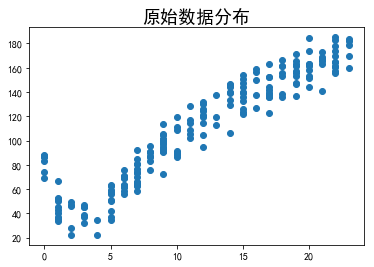

In [21]:
fig=plt.figure(figsize=(6,4))
ax1=fig.add_subplot(111)
ax1.scatter(trainMat[:,0].flatten().A[0],trainMat[:,1].flatten().A[0])
plt.title('原始数据分布',fontsize=18)

In [22]:
Y_regTree4=treePredictAll(regTree4,testMat,modelEval=regTreeEval)
Y_modelTree4=treePredictAll(modelTree4,testMat,modelEval=modelTreeEval)

ws,X,Y=linearSolve(trainMat)
Y_linearReg=mat(zeros((shape(testMat)[0],1)))
for i in range(shape(testMat)[0]):
    Y_linearReg[i,0]=modelTreeEval(ws,testMat[i,:(shape(testMat)[1]-1)])

print ('='.center(50,'='))
print ('回归树应用于测试集的相关系数为：{0}'.format(corrcoef(array(testMat[:,-1].T)[0],array(Y_regTree4.T)[0])[0,1]))
print ('模型树应用于测试集的相关系数为：{0}'.format(corrcoef(array(testMat[:,-1].T)[0],array(Y_modelTree4.T)[0])[0,1]))
print ('模型树应用于测试集的相关系数为：{0}'.format(corrcoef(array(testMat[:,-1].T)[0],array(Y_linearReg.T)[0])[0,1]))
print ('='.center(50,'='))

回归树应用于测试集的相关系数为：0.9587328585613937
模型树应用于测试集的相关系数为：0.9760412191380593
模型树应用于测试集的相关系数为：0.9434684235674762


- 可以看到，这此数据集上，模型树表现比回归树好,线性回归表现最差
- 说明树回归相比于线性回归，可以更好地处理复杂、非线性的数据集

### 4. GUI交互--tkinter模块
- 利用tkinter模块，与用户交互训练树回归模型，用模型预测测试集的值，并展示在图中
- 交互形式：用户通过GUI界面输入参数，程序根据参数训练模型，并利用模型进行预测，然后将预测结果通过GUI显示在界面中

In [23]:
from tkinter import *

In [422]:
#test1
top=tkinter.Tk()

li=['DS','Genius']
lista=tkinter.Listbox(top)
for i in range(len(li)):
    lista.insert(0,li[i])
    
B = tkinter.Button(top, text ="点我",activebackground='blue',activeforeground='yellow')
L=tkinter.Label(top,text='网站名')
E=tkinter.Entry(top,bd=5)

lista.pack()
B.pack()
L.pack(side='left')
E.pack(side='right')

top.mainloop()

In [430]:
#test2
master = Tk()

def var_states():
    print((var1.get(),var2.get()))

Label(master, text='Your sex:').grid(row=0,sticky=W)

var1 = BooleanVar()
Checkbutton(master, text='male', variable=var1).grid(row=1,sticky=W)

var2 = IntVar()
Checkbutton(master,text='female',variable=var2).grid(row=2,sticky=W)

Button(master,text='Quit',command=master.quit).grid(row=3,sticky=W,pady=4)
Button(master,text='Show',command=var_states).grid(row=4,sticky=W,pady=4)
mainloop()

(True, 0)
(False, 1)


### 交互：树回归模型的训练和使用
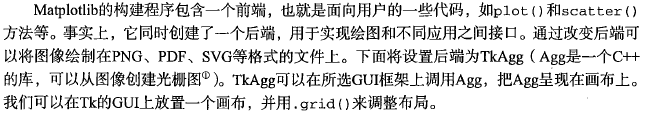

In [60]:
import matplotlib
matplotlib.use('TkAgg') #将matplotlib后端设置为TKAgg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

#获取用户在交互界面输入的参数
def getInputs():
    try:
        tolN=int(tolNentry.get())
    except:
        tolN=10
        print('请在tolN框格输入整数')
        tolNentry.delete(0,END)
        tolNentry.insert(0,'10')
    try:
        tolS=int(tolSentry.get())
    except:
        tolS=1.0
        print('请在tolS框格输入小数')
        tolSentry.delete(0,END)
        tolSentry.insert(0,'1.0')
    return tolS,tolN

#根据用户设定的参数和选择的模型，训练模型预测数据并画图
def reDraw(tolS,tolN):
    reDraw.f.clf() #清空画布
    reDraw.a=reDraw.f.add_subplot(111)
    if chkBtnVar.get(): #若用户选择了Model Tree建模
        myTree=createTree(reDraw.rawDat,leafType=modelLeaf,errType=modelErr,ops=(tolS,tolN))
        yPred=treePredictAll(myTree,reDraw.testDat,modelEval=modelTreeEval)
    else: #若用户选择了Regression Tree建模
        myTree=createTree(reDraw.rawDat,ops=(tolS,tolN))
        yPred=treePredictAll(myTree,reDraw.testDat)
    reDraw.a.scatter(reDraw.rawDat.T.tolist()[0],reDraw.rawDat.T.tolist()[1],s=10)
    reDraw.a.plot(reDraw.testDat.T.tolist()[0],yPred,linewidth=2.0,c='red')
    reDraw.canvas.show()
        
#结合reDraw()，getInputs()函数：获取用户在交互界面输入的参数，根据用户设定的参数和选择的模型，训练模型预测数据并画图
def drawNewTree():
    tolS,tolN=getInputs()
    reDraw(tolS,tolN)

#利用以上三个自定义函数，完成交互界面
root=Tk()

#展示画布
reDraw.f=Figure(figsize=(6,4),dpi=100)
reDraw.canvas=FigureCanvasTkAgg(reDraw.f,master=root)
reDraw.canvas.show()
reDraw.canvas.get_tk_widget().grid(row=0,columnspan=3)

#显示标签和按钮
Label(root,text="树回归模型参数调整交互").grid(row=1,column=0,columnspan=3)
Label(root,text="tolN").grid(row=2,column=0)
tolNentry=Entry(root)
tolNentry.grid(row=2,column=1)
tolNentry.insert(0,'10')

Label(root,text="tolS").grid(row=3,column=0)
tolSentry=Entry(root)
tolSentry.grid(row=3,column=1)
tolSentry.insert(0,'1.0')

Button(root,text="ReDraw",command=drawNewTree).grid(row=1,column=2,rowspan=4)

#若用户选择该按钮，则返回1，否则返回0，通过chkBtnVar.get()得到返回的值
chkBtnVar=IntVar() #设置为int变量
chkBtn=Checkbutton(root,text='Use Model Tree',variable=chkBtnVar)
chkBtn.grid(row=4,column=0,columnspan=2)

#读取数据，调用自定义函数
reDraw.rawDat=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch09\sine.txt')
testdataX=mat(arange(min(reDraw.rawDat[:,0]),max(reDraw.rawDat[:,0]),0.01)).T
reDraw.testDat=mat(zeros((shape(testdataX)[0],shape(testdataX)[1]+1)))
reDraw.testDat[:,:shape(testdataX)[1]]=testdataX
reDraw(1.0,10)

root.mainloop()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "E:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "E:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "E:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "E:\ProgramData\A

请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
请在tolS框格输入小数
